In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
from numpy.fft import rfft

import scipy
from scipy.signal import spectrogram

import ctypes
from ctypes import c_float, c_void_p
from ctypes import cdll
from ctypes import POINTER

libstft2 = cdll.LoadLibrary('./libstft.so')

# FFT
libstft2.create_fft_object.restype = c_void_p
libstft2.forward_rfft.restype = POINTER( c_float )

# STFT
libstft2.create_stftpack_object.restype = c_void_p
libstft2.forward_stft.restype = POINTER( POINTER( c_float ) )
libstft2.forward_spectrogram.restype = POINTER( POINTER( c_float ) )
libstft2.forward_log_spectrogram.restype = POINTER( POINTER( c_float ) )

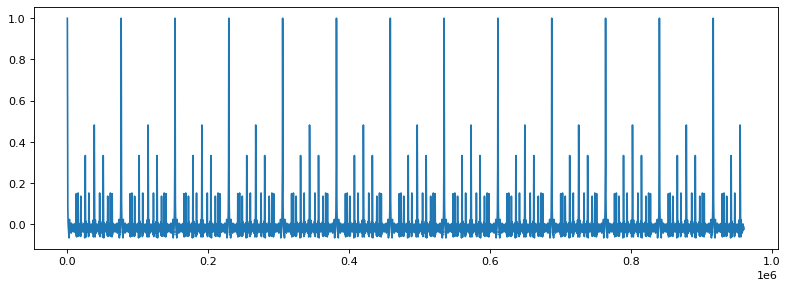

In [2]:
# Sample data
nsec = 60
bitrate = 16000

N = int(nsec*bitrate)
nperseg = 1024
noverlap = 512
eps = 1e-10

x = np.linspace(0, 8*np.pi, N)
y = np.sum([
    np.cos(1*k*np.pi*x)+ np.cos(2*k*np.pi*x) +\
    np.cos(3*k*np.pi*x) + np.cos(4*k*np.pi*x) +\
    np.cos(5*k*np.pi*x) + np.cos(6*k*np.pi*x)
    for k in range(1, 28)
], axis=0)

# Normalize
y = y/np.max(y)

# Convert to C array
c_arr = (c_float*len(y))(*y)

# Calculate matrix sizes
nrows = libstft2.calc_nrows(int(len(y)), nperseg, noverlap)
ncols = libstft2.calc_ncols(int(len(y)), nperseg, noverlap)

# Plot
plt.figure(figsize=(12,4), dpi=80)
plt.plot(y)

Scipy shape = (513, 1874)
STFT object created at 93962978423968
Result matrix is at <__main__.LP_LP_c_float object at 0x7f61637fa0d0>
Numpy result created
STFT object destroyed
C++ shape = (512, 1873)


Text(0.5, 1.05, 'C++ spectrogram')

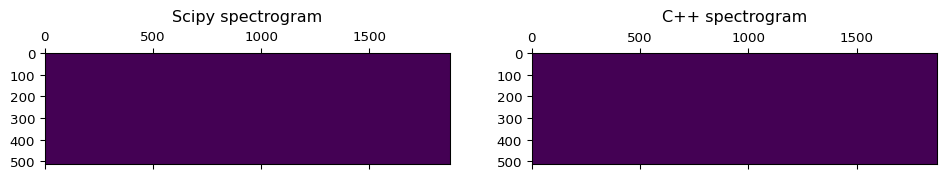

In [3]:
# Spectrogram with scipy and C++
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=96)

# Scipy spectrogram
t, f, S = spectrogram(y, nperseg=nperseg, noverlap=noverlap)
print("Scipy shape = {}".format(S.shape))
axes[0].matshow(S)
axes[0].set_title("Scipy spectrogram", pad=20)

# C++ spectrogram
stftobj = libstft2.create_stftpack_object(N, nperseg, noverlap, c_float(eps))
print("STFT object created at", stftobj)
ptr = libstft2.forward_spectrogram(c_void_p(stftobj), c_arr)
print("Result matrix is at", ptr)
np_result = np.stack([ptr[k][:ncols] for k in range(nrows)], axis=1)
print("Numpy result created")
libstft2.delete_stftpack_object(c_void_p(stftobj))
print("STFT object destroyed")

print("C++ shape = {}".format(np_result.shape))
axes[1].matshow(np_result[:,:])
axes[1].set_title("C++ spectrogram", pad=20)

Scipy shape = (513, 1874)
STFT object created at 93962974386256
Result matrix is at <__main__.LP_LP_c_float object at 0x7f616127ab70>
Numpy result created
STFT object destroyed
C++ shape = (512, 1873)


Text(0.5, 1.05, 'C++ log spectrogram')

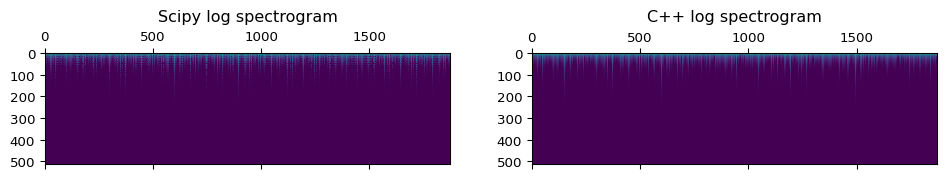

In [4]:
# Spectrogram with scipy and C++
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=96)

# Scipy spectrogram
t, f, S = spectrogram(y, nperseg=nperseg, noverlap=noverlap)
print("Scipy shape = {}".format(S.shape))
axes[0].matshow(np.log(eps+S))
axes[0].set_title("Scipy log spectrogram", pad=20)

# C++ spectrogram
stftobj = libstft2.create_stftpack_object(N, nperseg, noverlap, c_float(eps))
print("STFT object created at", stftobj)
ptr = libstft2.forward_log_spectrogram(c_void_p(stftobj), c_arr)
print("Result matrix is at", ptr)
np_result = np.stack([ptr[k][:ncols] for k in range(nrows)], axis=1)
print("Numpy result created")
libstft2.delete_stftpack_object(c_void_p(stftobj))
print("STFT object destroyed")

print("C++ shape = {}".format(np_result.shape))
axes[1].matshow(np_result[:,:])
axes[1].set_title("C++ log spectrogram", pad=20)

In [5]:
%%timeit
stftobj = libstft2.create_stftpack_object(N, nperseg, noverlap, c_float(eps))
ptr = libstft2.forward_log_spectrogram(c_void_p(stftobj), c_arr)
np_result = np.stack([ptr[k][:ncols] for k in range(nrows)], axis=1)
libstft2.delete_stftpack_object(c_void_p(stftobj))

323 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
